In [ ]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.5/709.5 kB 11.2 MB/s eta 0:00:00


In [ ]:
os.makedirs('datasets', exist_ok=True)

In [ ]:
%cd datasets

/content/datasets


In [ ]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

download_file(
    'https://www.dropbox.com/scl/fi/p620hxffhll75riuf2ygt/surgical-tools.v1i.yolov8.zip?rlkey=lz9g6rmhpijjuw8n6m5azgoqo&dl=1',
    'surgical_tool_dataset_v8.zip'
)

In [ ]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('surgical_tool_dataset_v8.zip')

Extracted all


In [ ]:
%cd ..

/content


In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()


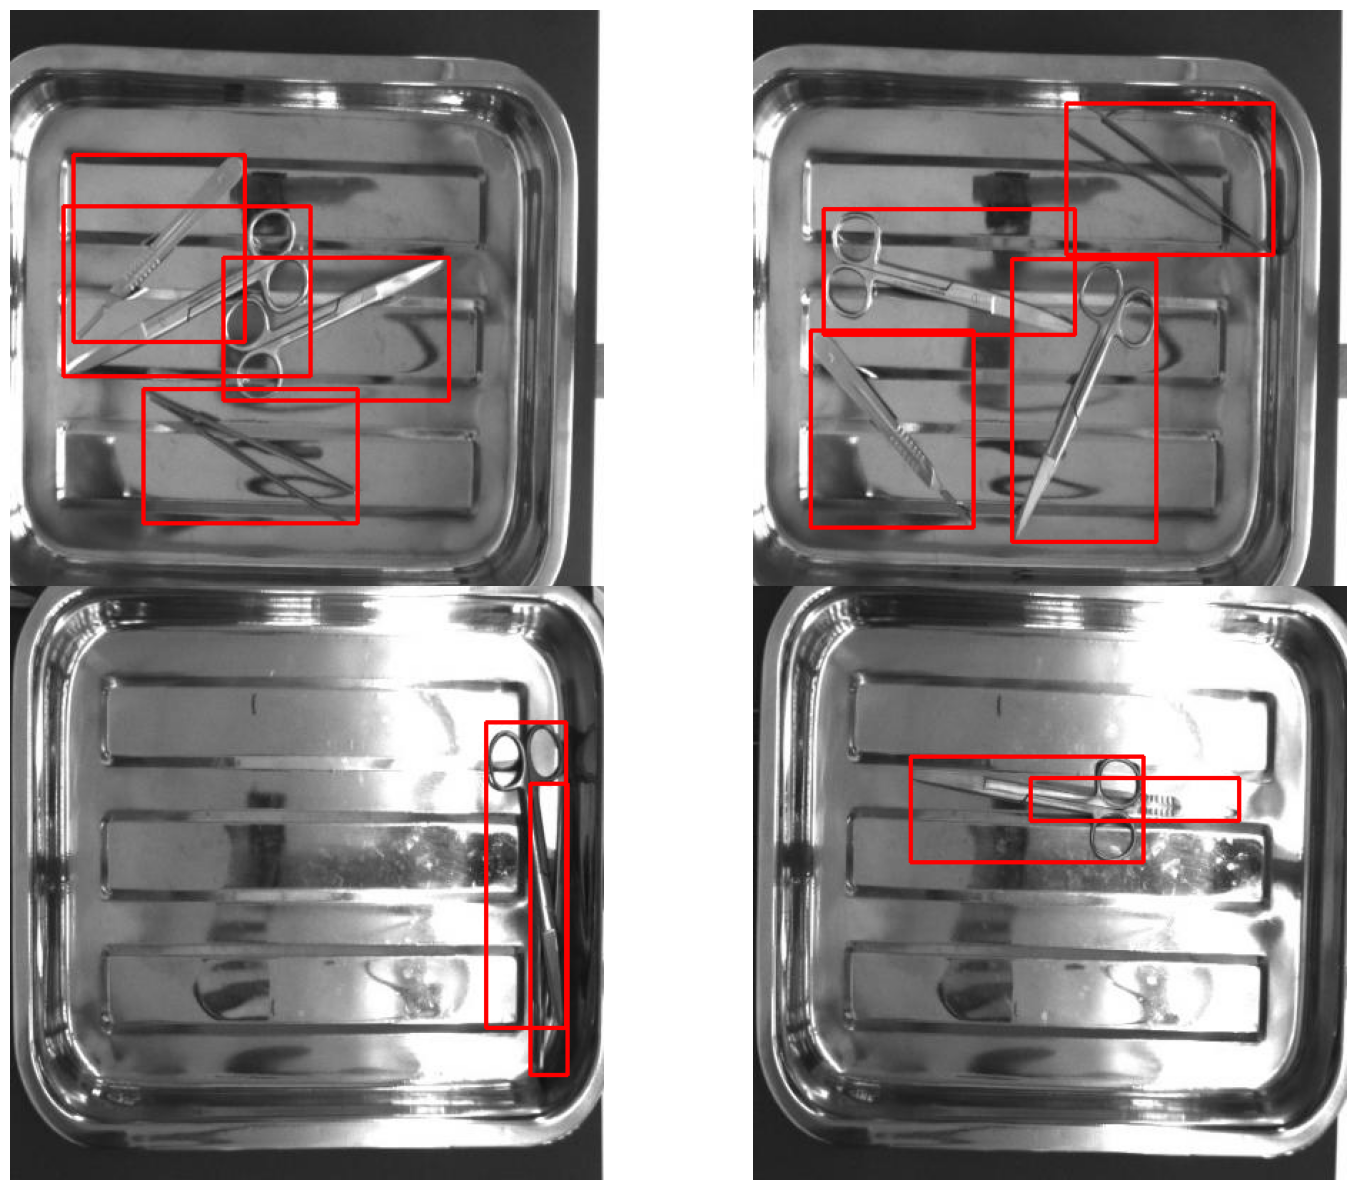

In [ ]:
# Visualize a few training images.
plot(
    image_paths='datasets/train/images/',
    label_paths='datasets/train/labels/',
    num_samples=4,
)

In [ ]:
%cd datasets/

/content/datasets


In [ ]:
%%writefile data.yaml
train: 'train/images'
val: 'valid/images'

# class names
names:
  0: '0'
  1: '1'
  2: '2'
  3: '3'

Overwriting data.yaml


In [ ]:
# Sample training for 5 epoch.
EPOCHS = 5
!yolo task=detect mode=train model=yolov8n.pt imgsz=1280 data=data.yaml epochs={EPOCHS} batch=8 name=yolov8n_v8_50e

Ultralytics YOLOv8.1.11 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=5, time=None, patience=50, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_50e2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

In [ ]:
pwd

'/content/datasets'

In [ ]:
!yolo task=detect mode=val model=runs/detect/yolov8n_v8_50e2/weights/best.pt name=yolov8n_eval data=data.yaml

Ultralytics YOLOv8.1.11 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/datasets/valid/labels.cache... 602 images, 0 backgrounds, 0 corrupt: 100% 602/602 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 38/38 [00:20<00:00,  1.81it/s]
                   all        602        836      0.613      0.769      0.652      0.483
                     0        602        206      0.856      0.666      0.826       0.59
                     1        602        224      0.589      0.665      0.661      0.464
                     2        602        204      0.527      0.784      0.619      0.492
                     3        602        202      0.482      0.962        0.5      0.386
Speed: 3.4ms preprocess, 15.5ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/yolov8n_eval
💡 Learn more at 

In [ ]:
ls -l

total 61468
-rw-r--r-- 1 root root      101 Feb 10 17:25 data.yaml
-rw-r--r-- 1 root root      152 Feb 10 17:15 README.dataset.txt
-rw-r--r-- 1 root root      998 Feb 10 17:15 README.roboflow.txt
drwxr-xr-x 3 root root     4096 Feb 10 17:25 runs/
-rw-r--r-- 1 root root 56370649 Feb 10 17:14 surgical_tool_dataset_v8.zip
drwxr-xr-x 4 root root     4096 Feb 10 17:15 test/
drwxr-xr-x 4 root root     4096 Feb 10 17:25 train/
drwxr-xr-x 4 root root     4096 Feb 10 17:25 valid/
-rw-r--r-- 1 root root  6534387 Feb 10 17:25 yolov8n.pt


In [ ]:
!yolo task=detect \
mode=predict \
model=runs/detect/yolov8n_v8_50e2/weights/best.pt \
source=valid/images \
imgsz=1280 \
name=yolov8n_v8_50e_infer1280 \
hide_labels=True

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.1.11 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs

image 1/602 /content/datasets/valid/images/bisturi104_jpg.rf.f32e785b562e3d280f5585ac7fa2a7b7.jpg: 1280x1280 1 0, 19.6ms
image 2/602 /content/datasets/valid/images/bisturi110_jpg.rf.82e3812267fba9faae76bd2c03d700a9.jpg: 1280x1280 1 0, 19.6ms
image 3/602 /content/datasets/valid/images/bisturi113_jpg.rf.0bce318a38268424126c7c22099ee02b.jpg: 1280x1280 1 0, 19.5ms
image 4/602 /content/datasets/valid/images/bisturi115_jpg.rf.4dd84b89cda364a57262ac687dc1e0e0.jpg: 1280x1280 1 0, 19.5ms
image 5/602 /content/datasets/valid/images/bisturi118_jpg.rf.7d49f4d2aabcbeb6a8ac29d7bd735fb9.jpg: 1280x1280 1 0, 19.5ms
image 6/602 /content/datasets/valid/images/bisturi119_jpg.rf.9a4a40bcfd29de03b363bb82

In [ ]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

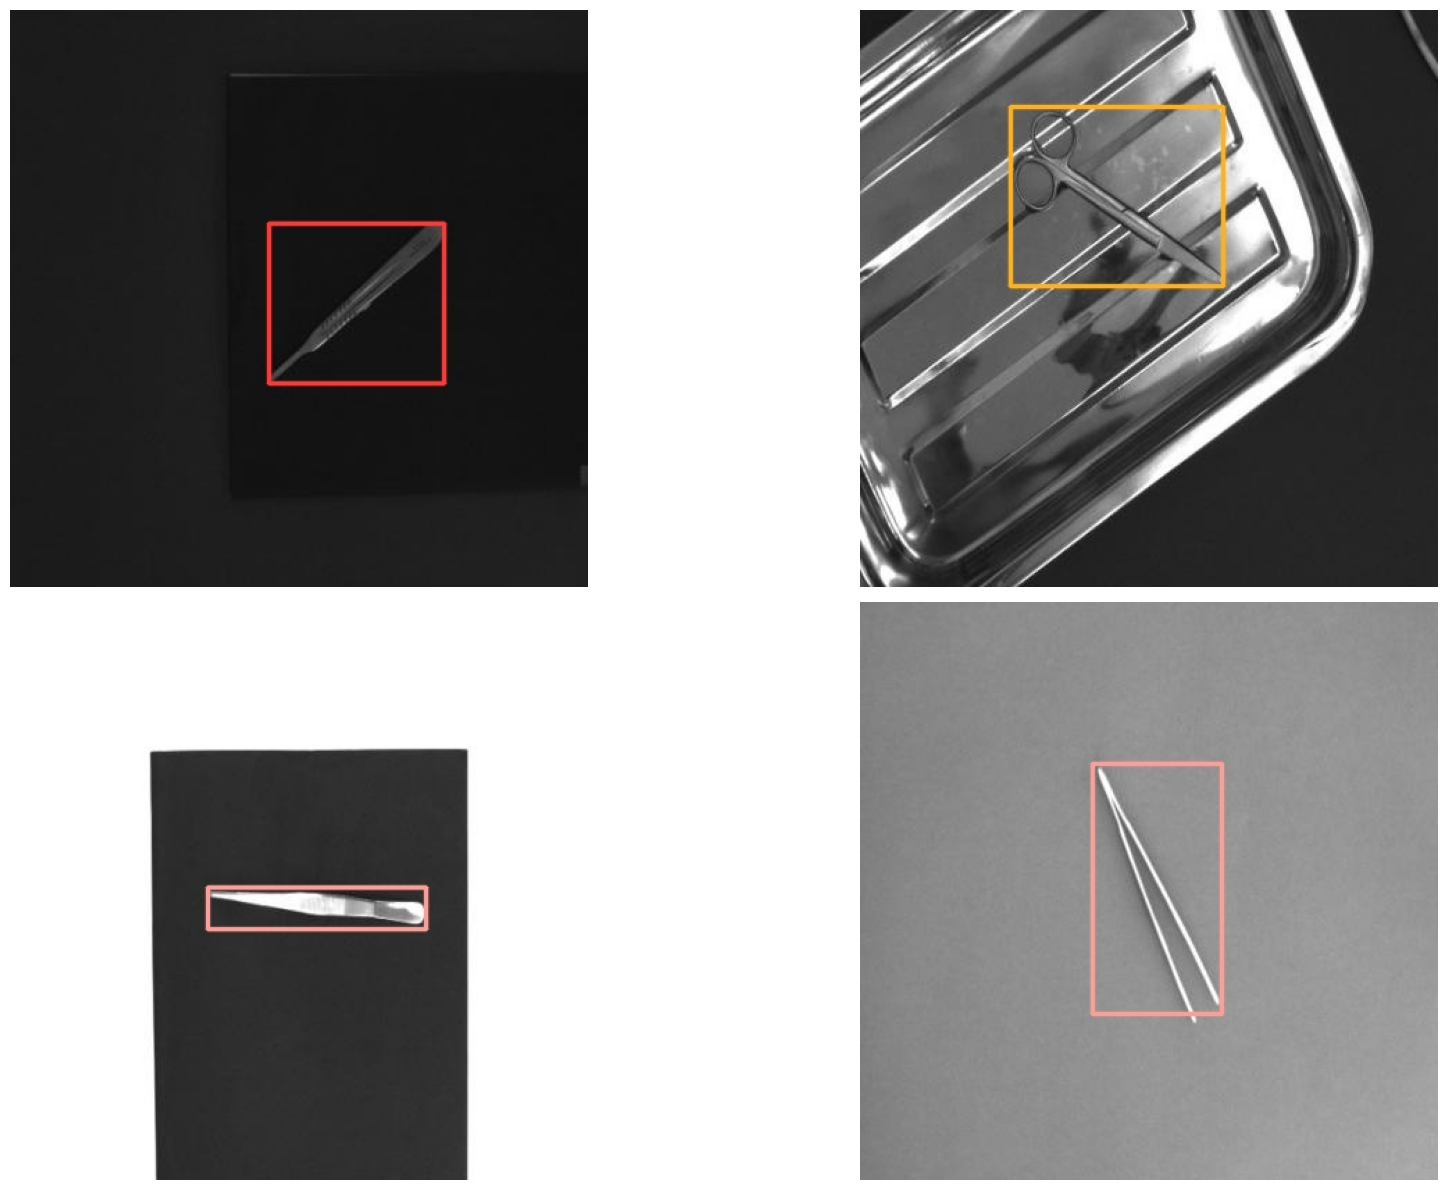

In [48]:
visualize('runs/detect/yolov8n_v8_50e_infer1280/')

In [ ]:
import onnx

model = onnx.load("model.onnx")

In [ ]:
yolo export \
model=yolov8s-seg.pt \
imgsz=[640,640] \
format=onnx \
opset=12